In [4]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel

import trc_funcs as trc

In [2]:
# star1 = lk.search_lightcurve('KIC 893507', quarter=10).download(flux_column='sap_flux')
# star1 = lk.search_lightcurve('TIC 99180739',sector=10,author='SPOC').download(flux_column='sap_flux')




# For FFIs

## following https://heasarc.gsfc.nasa.gov/docs/tess/NoiseRemovalv2.html

In [16]:
sector=3
ID=396696273
cutoutsize=11
# ffi1 = lk.search_tesscut('TIC '+str(ID), 
#                          sector=sector).download(cutout_size=(cutoutsize,cutoutsize))

# try toi 1136
sector=14; name='TOI 1136';
ffi1 = lk.search_tesscut(name,sector=sector).download(cutout_size=(cutoutsize,cutoutsize))

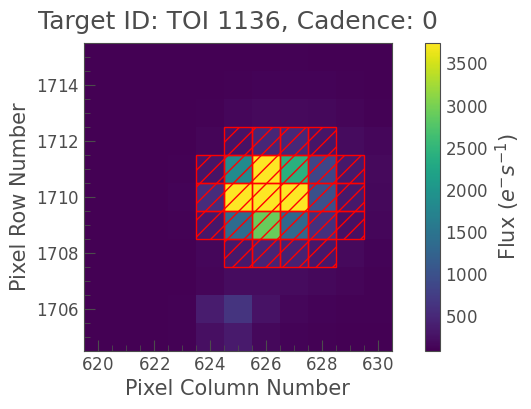

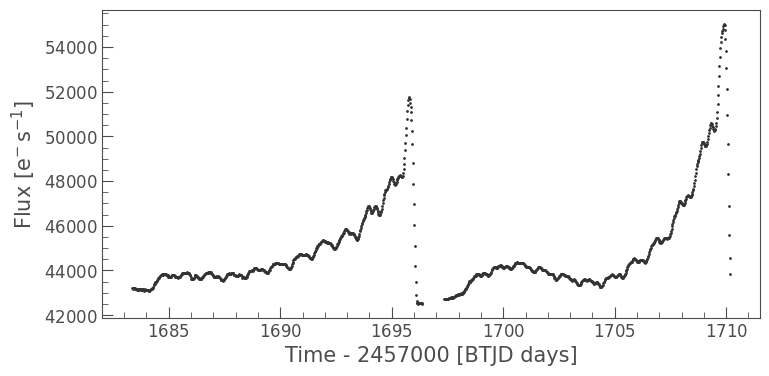

In [18]:
threshold=3

ffi1.plot(aperture_mask=ffi1.create_threshold_mask(threshold))
plt.show()

star1 = ffi1.to_lightcurve(aperture_mask=ffi1.create_threshold_mask(threshold))
star1.scatter()
plt.show()

# TESS tools for FFI background subtracted SAP

In [5]:
# Frankenstein'd code from NEMESIS pipeline (https://iopscience.iop.org/article/10.3847/1538-3881/abedb3/meta)

def create_circular_mask(median_image, reference_pixel, radius=1):
    h, w = median_image.shape[:2]
    if reference_pixel is None: # use the middle of the image, this is a fair assumption for TPFs which are pre-centered,
        #                       # on targets. FFIs, not so much... 
        reference_pixel = (int(h/2), int(w/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(reference_pixel[0], reference_pixel[1], h-reference_pixel[0], w-reference_pixel[1])
    #
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - reference_pixel[0])**2 + (Y-reference_pixel[1])**2)
    #
    mask = dist_from_center <= radius
    return mask
#
def thresholdmask(hdu,reference_pixel,threshold,use_centroid=False,use_circ=True):
    import numpy as np
    ### threshold higher is more conservative, lower is more liberal
    ### define image from image data
    median_image = np.nanmedian(hdu[1].data['FLUX'], axis=0)
    vals=median_image[np.isfinite(median_image)].flatten()
    ###
    from astropy.stats.funcs import median_absolute_deviation as MAD
    ###
    # A value for the number of sigma by which a pixel needs to be
    # brighter than the median flux to be included in the aperture:
    ###
    MADcut = ( 1.4826*MAD(vals)*threshold +np.nanmedian(median_image))
    threshold_mask = np.nan_to_num(median_image) > MADcut
    #
    #
    if (reference_pixel == None):
        # return all regions above threshold
        return threshold_mask
    #
    #
    ###
    from scipy.ndimage import label #<--converts image to 1s and 0s as "labels"
    labels = label(threshold_mask)[0]
    label_args = np.argwhere(labels > 0)
    ###
    ### For all pixels above threshold, compute distance to reference pixel:
    distances = [np.hypot(crd[0], crd[1]) for crd in label_args - np.array([reference_pixel[1], reference_pixel[0]])]
    ###
    ### Which label corresponds to the closest pixel?
    closest_arg = label_args[np.argmin(distances)]
    closest_label = labels[closest_arg[0], closest_arg[1]]
    ###
    threshmask=labels==closest_label
    ###
    # BELOW SHOULD ONLY BE DONE IF use_centroid==True!!!
    #if use_centroid==True:
    #check if thresmask is ACTUALLY close to reference_pixel 
    ###
    tx,ty=centroid_quadratic(median_image, threshmask, reference_pixel)
    ###
    dist_from_ref = np.round(np.sqrt( (tx-reference_pixel[0])**2 + (ty-reference_pixel[1])**2  ),2)
    if use_circ==True:
        if dist_from_ref > 1.5:
            r=1.5
            print('selected aperture mask is ',dist_from_ref,'pixels from reference pixel! Using circular aperture (r = '+str(r)+' pixels) around reference pixel instead')
            #
            #
            circ_mask = create_circular_mask(median_image, reference_pixel, radius=r)
            threshmask = circ_mask
        else:
            threshmask=threshmask
    if use_circ==False:
        threshmask=threshmask
    ###
    if use_centroid==False:
        reference_pixel = reference_pixel
    if use_centroid==True:
        reference_pixel = centroid_quadratic( median_image, threshmask, reference_pixel)
    return threshmask            
#
def centroid_quadratic(data, mask, reference_pixel):
    # Step 1: identify the patch of 3x3 pixels (z_)
    # that is centered on the brightest pixel (xx, yy)
    if mask is not None:
        data = data * mask
    arg_data_max = np.nanargmax(data)
    yy, xx = np.unravel_index(arg_data_max, data.shape)
    #    
    # Make sure the 3x3 patch does not leave the image bounds
    if yy < 1:
        yy = 1
    if xx < 1:
        xx = 1
    if yy > (data.shape[0] - 2):
        yy = data.shape[0] - 2
    if xx > (data.shape[1] - 2):
        xx = data.shape[1] - 2
    #
    z_ = data[yy-1:yy+2, xx-1:xx+2]
    #
    # Next, we will fit the coefficients of the bivariate quadratic with the
    # help of a design matrix (A) as defined by Eqn 20 in Vakili & Hogg
    # (arxiv:1610.05873). The design matrix contains a
    # column of ones followed by pixel coordinates: x, y, x**2, xy, y**2.
    #
    A = np.array([[1, -1, -1, 1,  1, 1],
                  [1,  0, -1, 0,  0, 1],
                  [1,  1, -1, 1, -1, 1],
                  [1, -1,  0, 1,  0, 0],
                  [1,  0,  0, 0,  1, 0],
                  [1,  1,  0, 1,  0, 0],
                  [1, -1,  1, 1, -1, 1],
                  [1,  0,  1, 0,  0, 1],
                  [1,  1,  1, 1,  1, 1]])
    #
    # We also pre-compute $(A^t A)^-1 A^t$, cf. Eqn 21 in Vakili & Hogg.
    At = A.transpose()
    #
    # In Python 3 this can become `Aprime = np.linalg.inv(At @ A) @ At`
    Aprime = np.matmul(np.linalg.inv(np.matmul(At, A)), At)
    #
    # Step 2: fit the polynomial $P = a + bx + cy + dx^2 + exy + fy^2$
    # following Equation 21 in Vakili & Hogg.
    # In Python 3 this can become `Aprime @ z_.flatten()`
    a, b, c, d, e, f = np.matmul(Aprime, z_.flatten()) #dot product
    #
    # Step 3: analytically find the function maximum,
    # following https://en.wikipedia.org/wiki/Quadratic_function
    det = 4.0 * d * f - (e ** 2.0)
#     if abs(det) < 1e-6:
#         return np.nan, np.nan  # No solution
    xm = - (2.0 * f * b - c * e) / det
    ym = - (2.0 * d * c - b * e) / det
    #
    return np.array(xx + xm), np.array(yy + ym)
#

def SAP(ID,Sector,cutoutsize,hdu,quality_mask,threshold,
        cadence,reference_pixel,verbose,fmt,scale,flux_unit,mission,
        use_SPOC_aperture=False,
        use_centroid=False,use_circ=True,use_sources_in_aperture=False):
    import numpy as np
    quality_mask = hdu[1].data['QUALITY']!=0
    median_image = np.nanmedian(hdu[1].data['FLUX'][~quality_mask], axis=0)
    ###
    ###
    flux = hdu[1].data['FLUX'][~quality_mask]
    rawtime = hdu[1].data['TIME'][~quality_mask]
    #include only finite values, excluding NaNs
    m = np.any(np.isfinite(flux),axis=(1,2))
    rawtime = np.ascontiguousarray(rawtime[m],dtype=np.float64)
    flux = np.ascontiguousarray(flux[m],dtype=np.float64)
    ###
    ###
    # find dimmest pixels using inverted threshold mask
    bkg_mask = ~thresholdmask(hdu,reference_pixel=None,threshold=1/1000,\
                              use_centroid=use_centroid,use_circ=use_circ)
    ###
    ### double check that reference pixel makes sense
    if (reference_pixel[0] > cutoutsize) or (reference_pixel[1] > cutoutsize):
        print('refernece pixel is larger than cutout!?!')
        print(reference_pixel)
        reference_pixel = [cutoutsize/2,cutoutsize/2] #assume it's in middle
        print(reference_pixel)
    ###
    ###
    # select brightest pixels using threshold mask
    try:
        T=threshold
        threshmask=thresholdmask(hdu,reference_pixel,threshold=T,\
                                 use_centroid=use_centroid,use_circ=use_circ)
    except ValueError as e:
        try:
            T=threshold/2.0
            print('threshold too high, no pixels selected. Trying half of input threshold: ',str(T))
            threshmask=thresholdmask(hdu,reference_pixel,threshold=T,\
                                     use_centroid=use_centroid,use_circ=use_circ)
        except ValueError as ee:
            try:
                T=threshold/3.0
                print('threshold STILL too high, no pixels selected. Trying third of input threshold: ',str(T))
                threshmask=thresholdmask(hdu,reference_pixel,threshold=T,\
                                         use_centroid=use_centroid,use_circ=use_circ)
            except ValueError as eee:
                print('setting threshold=1 (last resort)')
                T=1.0
                try:
                    threshmask=thresholdmask(hdu,reference_pixel,threshold=T,\
                                             use_centroid=use_centroid,use_circ=use_circ)
                except ValueError as eeee:
                    print('Ok, I tried...')
                    pass
    try:
        pix_mask=threshmask
        if verbose==True:
            print('selected threshold: ',T)
    except UnboundLocalError as UE:
        print('unable to find suitable threshold mask')
        return
    #
    if (cadence=='short') or (cadence=='2 minute') or (cadence=='20 second') or (cadence=='fast'):
        if use_SPOC_aperture==True:
            print('using SPOC aperture')
            try:
                pipeline_mask = hdu[2].data & 2 > 0
            except TypeError:  # Early versions of TESScut returned floats in HDU 2
                pipeline_mask = np.ones(hdu[2].data.shape, dtype=bool)
            pix_mask = pipeline_mask
            bkg_mask = ~pipeline_mask
        if use_SPOC_aperture==False:
            if verbose==True:
                print('using threshold mask')
    ###
    ###
    rawflux = np.nansum(flux[:, pix_mask], axis=-1)
    bkgFlux = np.nansum(flux[:, bkg_mask], axis=-1)
    #
    Npixbkg = len(np.where(bkg_mask == True)[0])
    Npixaper= len(np.where(pix_mask == True)[0])
    #
    bkgFlux = bkgFlux/Npixbkg #normalize background
    #
    rawsap_flux = rawflux - (bkgFlux * Npixaper)
    sap_flux = rawsap_flux #/ np.nanmedian(rawsap_flux)
    #    
    #
    #
    nanmask = np.where(np.isfinite(sap_flux)==True)[0]
    #print('len SAP nanmask',len(nanmask))
    error = np.abs( sap_flux / np.nanmedian(np.nansum(sap_flux)/np.nanmedian(sap_flux)))
    error = np.abs( sap_flux / np.nanmedian(np.nansum(sap_flux)))    
    #print('len E before nanmask',len(error))
    error =error[nanmask]
    #
    if verbose==True:
        print('len check ',' T', len(rawtime),' SAP',len(sap_flux), ' E ', len(error))
        print('shape check ',' T', np.shape(rawtime),' SAP',np.shape(sap_flux), ' E ', np.shape(error))
    #SAP_LC = pd.DataFrame({"Time":rawtime,"RAW SAP Flux":rawsap_flux,"SAP Flux":sap_flux,"SAP Error":error, "Background Flux":bkgFlux})
    import astropy.units as u
    from astropy.time import Time
    rawtime = Time(rawtime, format=fmt, scale=scale)
#     sap_flux *= (u.def_unit('e-')/u.second)
    sap_flux *= flux_unit
    error = u.Quantity(error, sap_flux.unit)
    print(sap_flux.unit,error.unit)
    SAP_LC = lk.LightCurve(time=rawtime,flux=sap_flux,
                           flux_err=error)
    SAP_LC.mission=mission
    if verbose==True:
        print('RAW len check:', len(rawtime),len(sap_flux),len(error))
    return SAP_LC

selected threshold:  3
len check   T 1237  SAP 1237  E  1237
shape check   T (1237,)  SAP (1237,)  E  (1237,)
electron / s electron / s
RAW len check: 1237 1237 1237


<ipython-input-5-83a04a62fadc>:245: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
  SAP_LC.mission=mission


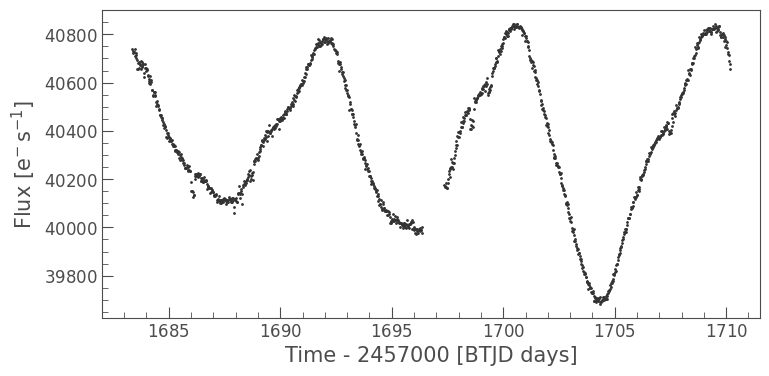

In [19]:
hdu = ffi1.hdu
quality_mask = hdu[1].data['QUALITY']!=0
cadence='30 minute'
if (cadence=='short') or (cadence=='fast') or (cadence=='2 minute') or (cadence=='20 second') :
    x=hdu[1].header['1CRPX4']-1 # in this case, TPFs are already centered
    y=hdu[1].header['2CRPX4']-1 # subtracting by one places coord on center, from testing they're always off by 1...
if (cadence=='long') or (cadence=='30 minute') or (cadence=='10 minute'):
    x=hdu[1].header['1CRPX4']-0.5 #subtracting by 0.5 places coord on center of pixel
    y=hdu[1].header['2CRPX4']-0.5 #otherwise it's on corner of pixel
reference_pixel=[x,y]
verbose=True

#defining time scale from FFI Raw LC
fmt=star1.time.format; scale=star1.time.scale
flux_unit = star1.flux.unit
mission=star1.mission
sap_lc = SAP(ID,Sector,cutoutsize,hdu,quality_mask,
             threshold,cadence,reference_pixel,
             verbose,fmt,scale,flux_unit,mission,
             use_SPOC_aperture=False,
             use_centroid=False,use_circ=True,
             use_sources_in_aperture=False)
sap_lc.scatter()
plt.show()

In [20]:
sap_lc.mission, star1.mission

('TESS', 'TESS')

In [21]:
# rewrite flux values with background subtracted flux
star1.flux=sap_lc.flux
star1.flux_err=sap_lc.flux_err

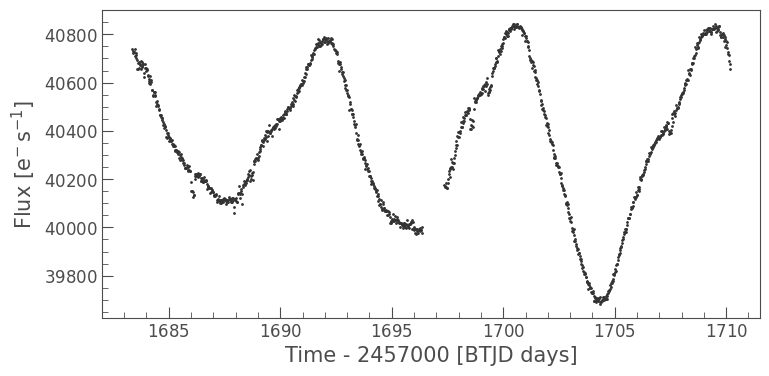

In [22]:
star1.scatter()
plt.show()

In [23]:
from lightkurve.correctors import CBVCorrector
cbvCorrector = CBVCorrector(star1, interpolate_cbvs=True)
cbvCorrector.cbvs

[TESS CBVs, Sector.Camera.CCD : 14.4.1, CBVType : SingleScale, nCBVS : 16,
 TESS CBVs, Sector.Camera.CCD : 14.4.1, CBVType.Band: MultiScale.1, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 14.4.1, CBVType.Band: MultiScale.2, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 14.4.1, CBVType.Band: MultiScale.3, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 14.4.1, CBVType : Spike, nCBVS : 5]

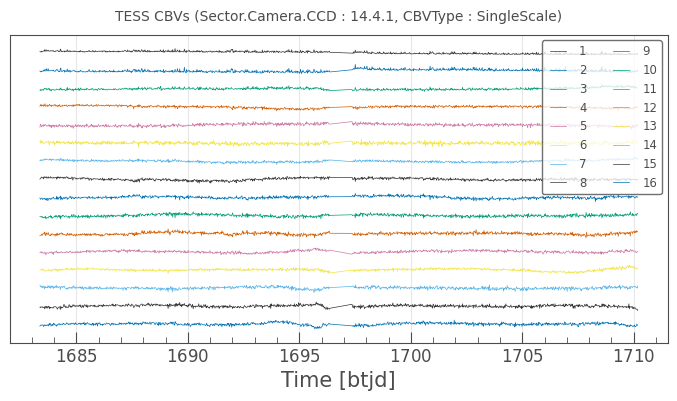

In [24]:
cbvCorrector.cbvs[0].plot()
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/metrics.py:117: RuntimeWarning: overflow encountered in exp
  return 2.0 / (1 + np.exp(x))
/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/metrics.py:117: RuntimeWarning: overflow encountered in exp
  return 2.0 / (1 + np.exp(x))
/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/metrics.py:117: RuntimeWarning: overflow encountered in exp
  return 2.0 / (1 + np.exp(x))
/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/metrics.py:117: RuntimeWarning: overflow encountered in exp
  return 2.0 / (1 + np.exp(x))
/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/metrics.py:117: RuntimeWarning: overflow encountered in exp
  return 2.0 / (1 + np.exp(x))
/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/metrics.py:117: RuntimeWarning: overflow encountered in exp
  return 2.0 / (1 + np.exp(x))
/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors

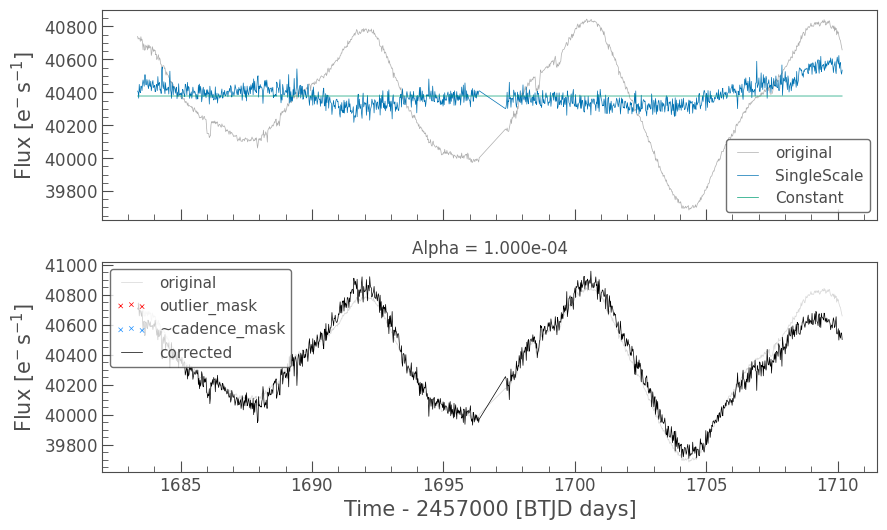

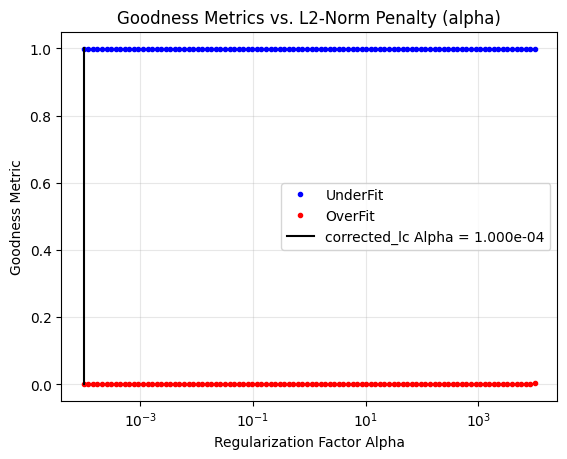

Over fitting Metric: 0.0
Under fitting Metric: 0.9978318297740286


/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/metrics.py:117: RuntimeWarning: overflow encountered in exp
  return 2.0 / (1 + np.exp(x))


In [25]:
# cbv_type = ['MultiScale.1', 'MultiScale.2', 'MultiScale.3','Spike']
# cbv_indices = [np.arange(1,9), np.arange(1,9), np.arange(1,9), 'ALL']
#above takes LONG time

cbv_type = ['SingleScale'] 
cbv_indices = [np.arange(1,9)]#, np.arange(1,9), np.arange(1,9), 'ALL']


cbvCorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, 
                                    alpha=1e-4)
cbvCorrector.diagnose();
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);
plt.show()

print('Over fitting Metric: {}'.format(cbvCorrector.over_fitting_metric()))
print('Under fitting Metric: {}'.format(cbvCorrector.under_fitting_metric()))

/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/metrics.py:117: RuntimeWarning: overflow encountered in exp
  return 2.0 / (1 + np.exp(x))
/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/metrics.py:117: RuntimeWarning: overflow encountered in exp
  return 2.0 / (1 + np.exp(x))


Optimized Over-fitting metric: 0.0
Optimized Under-fitting metric: 0.997830717434705
Optimized Alpha: 3.881e-09


/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/metrics.py:117: RuntimeWarning: overflow encountered in exp
  return 2.0 / (1 + np.exp(x))
/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/metrics.py:117: RuntimeWarning: overflow encountered in exp
  return 2.0 / (1 + np.exp(x))
/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/metrics.py:117: RuntimeWarning: overflow encountered in exp
  return 2.0 / (1 + np.exp(x))
/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/metrics.py:117: RuntimeWarning: overflow encountered in exp
  return 2.0 / (1 + np.exp(x))
/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/metrics.py:117: RuntimeWarning: overflow encountered in exp
  return 2.0 / (1 + np.exp(x))
/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/metrics.py:117: RuntimeWarning: overflow encountered in exp
  return 2.0 / (1 + np.exp(x))
/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors

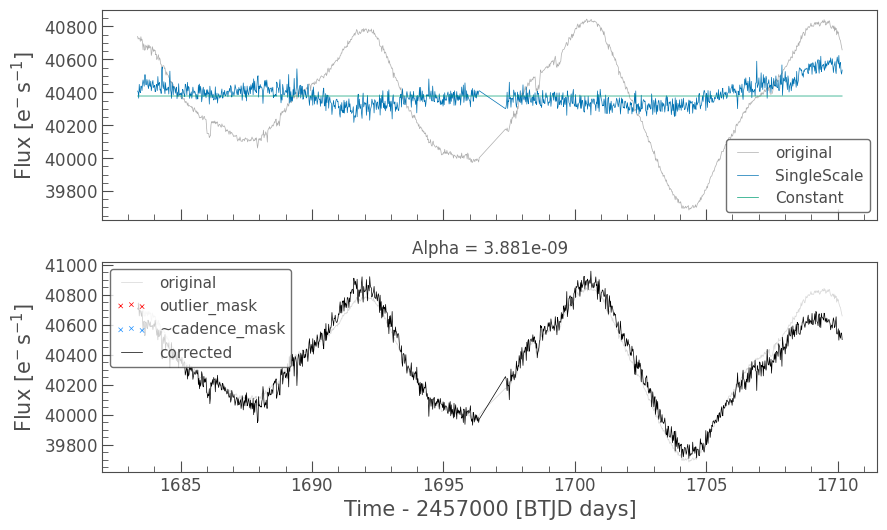

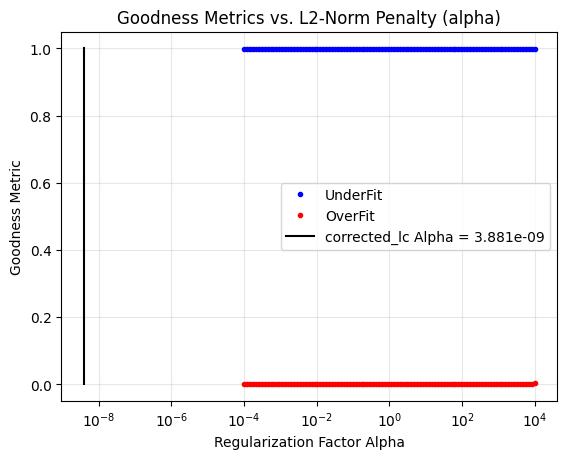

/opt/anaconda3/lib/python3.8/site-packages/lightkurve/correctors/metrics.py:117: RuntimeWarning: overflow encountered in exp
  return 2.0 / (1 + np.exp(x))


Over fitting Metric: 0.0
Under fitting Metric: 0.997830717434705


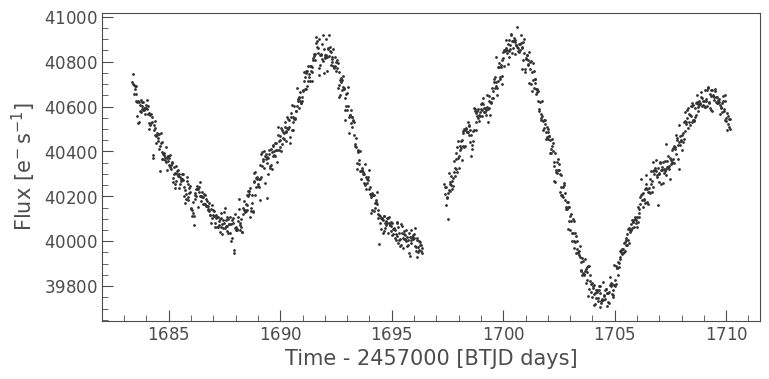

In [45]:
# corr_lc = cbvCorrector.correct(cbv_type=cbv_type,
#                                cbv_indices=cbv_indices,
#                                alpha_bounds=[1e-4,1e-3])   
corr_lc = cbvCorrector.correct(cbv_type=cbv_type,
                               cbv_indices=cbv_indices,
                               alpha_bounds=[1e-10,1e-8])     
                       

cbvCorrector.diagnose()

cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);
plt.show()
print('Over fitting Metric: {}'.format(cbvCorrector.over_fitting_metric()))
print('Under fitting Metric: {}'.format(cbvCorrector.under_fitting_metric()))

corr_lc.scatter()
plt.show()

In [27]:
# download the pipeline sap and compare
# try toi 1136
sector=14
name = 'TOI 1136'
lc_pip = lk.search_lightcurve(name,sector=sector, author='SPOC').download(cutout_size=(cutoutsize,cutoutsize))

/opt/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:315: LightkurveWarning: `cutout_size` can only be specified for TESS Full Frame Image cutouts.
  warnings.warn(


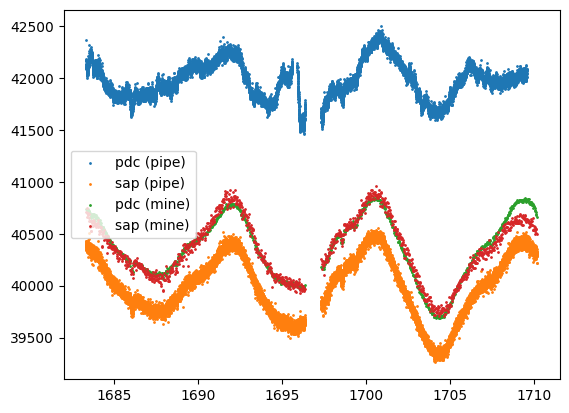

In [46]:
plt.scatter(lc_pip.time.value, lc_pip.pdcsap_flux.value, s=1, label='pdc (pipe)')
plt.scatter(lc_pip.time.value, lc_pip.sap_flux.value, s=1, label='sap (pipe)')
plt.scatter(corr_lc.time.value, sap_lc.flux, s=1, label='pdc (mine)')
plt.scatter(corr_lc.time.value, corr_lc.flux.value, s=1, label='sap (mine)')
plt.legend()
plt.show()
